# Explainable diagnostics with quantum computing

Autistic Spectrum Disorder (ASD) represents a neurodevelopmental condition linked to considerable healthcare expenses. Early detection plays a pivotal role in mitigating these costs. The economic impact of autism and the increase in the number of ASD cases across the world reveals an urgent need for the development of easily implemented and effective screening methods.


This notebook aims to generate an explicable quantum machine learning method to automate disgnostics for mental health conditions. In this example, we will be working with an Autisitc Spectrum Disorder dataset, which consists of a set of binary answers to questionnaires. With such answers, our aim is to predict the probability of having ASD. For more information about the dataset, see the associated `Autism-Screening-Adult-Data Description document`.


In [75]:
import pennylane as qml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from pennylane import numpy as qnp

## Load data

Let's begin by loading the dataset

In [76]:
# Load data
columns = ['q'+ str(i) for i in range(10)] + ['Age', 'Gender', 'Ethnicity', 'Born', 'Family', 'Who', 'Country', 'Used', 'Group','Screening', 'Score']
data=pd.read_csv('ASD_dataset.arff', sep=',', header=None)
data.columns = columns
data = data.replace({'NO':0, 'YES':1})
data.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,Gender,Ethnicity,Born,Family,Who,Country,Used,Group,Screening,Score
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,0
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,0
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,1
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,0
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2,'18 and more',?,0


As you can see, the dataset contains 10 binary questions (0 = NO, 1= YES), plus some additional information from the patient. In this example, we will use the answers to the questions to predict the probability of having ASD. Having an automated tool like this one helps the physicians make faster and accurate diagnostics. 

## Creating our dataset

In our case, X will be the set of answers to the questions (which in this case correspond to a binary vector). The target y will be the probability of having ASD given the answers to the questions.
For simplicity, we will reduce the number of questions that we choose. Since our dataset is not very long, we want to identify small sets of questions that explain, with high probability, the chances of having ASD. 
This provides explainable diagnostics to the patients. Let's select 6 features, for example.

In [77]:
# Create X and Y data
num_feat = 6 # We can reduce the number of questions to simplify the model
X = data.iloc[:,:num_feat]
Y = data.iloc[:,-1]
Z = data.iloc[:,[i for i in range(num_feat)] + [20]]
print(X.shape, Y.shape, Z.shape)

(704, 6) (704,) (704, 7)


Now, let's calculate the probability of having ASD given a particular set of answers to the questions.

In [78]:
# Map to probabilities
probs = []
for i in range(X.shape[0]):
    val = X.iloc[i]
    Z_sel = Z.query(" and ".join(["q" + str(k) +"==" + str(val[k]) for k in range(len(val))]))
    probs.append(Z_sel['Score'].mean())    
probs = np.array(probs)

C:\Users\laiad\AppData\Local\Temp\ipykernel_15228\3414139979.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z_sel = Z.query(" and ".join(["q" + str(k) +"==" + str(val[k]) for k in range(len(val))]))


## Preprocessing

We split the data into training, validation and test sets. Remember that the training set is used to train the model, the validation set is used to evaluate different predictive models and select the most optimal one, and the test set provides an estimation of the final performance. 

In [79]:
X_train, X_val, y_train, y_val = train_test_split( X.values, probs, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
print(y_train.shape, y_val.shape, y_test.shape)

(598,) (53,) (53,)


## Quantum Neural Network


Let us build a Quantum Neural Network (QNN) to predict the probability of ASD. The architecture of the QNN is the following:

+ **Data encoding**: The first step is to encode our training data (the answers to the questions) in our quantu circuit. For this, we will use *Basis Embedding*, which maps a binary vector $b = (0110...)$ to a quantum state $|0110...>$. There is a small problem with the Basis Embedding function in Pennylane, that does not work properly with pytorch (a bug!). Until they solve it, we will find a workaround, by generating a vector that we can encode with amplitude encoding and that gives the same output as the Basis Embedding. For example, consider the input data (00). We would transform these answers to the vector (1000) (first vector of the Hilber space). Similarly, we would transform (01) -> (0100), (10) -> (0010) and (11) -> (0001). Then, encoding these vectors with amplitude encoding would give us the states |00>, |01>, |10> and |11>. 

+ **Variational model**: The next step is to provide a quantum variational model that combines the input information to make useful predictions. In this case, we will use a layered ansatz, each layer being composed by *Strongly Entangling Layers* (see https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html). You can play with the number of layers and also explore other architectures.

+ **Measurements**: The quantum neural network finishes with a measurement that retrieves classical information.  In this example, we will use $N$ qubits to encode the data ($N$ = number of features) and 1 qubit to measure the probability of having ASD. In this way, we will measure the probability of qubit 1 being in the 0 state. 

+ **Classical layer**: In this example we will create a hybrid neural network (a combination of classical and quantum layers). While the measurement could already be the prediction of our model, we will add an extra classical layer to give variablity to the model. This classical layer will simply be a fully connected layer with RELU activation function. This combines linear and non-linear classical functions.

Let's startt by preparing the input data to apply (artificial) amplitude encoding.

In [80]:
def amplitude_vector(X):
    # Convert the binary vectors to decimal
    X_decimal = []
    for i in range(X.shape[0]):
        X_decimal.append(int(''.join([str(a) for a in X[i]]),2))
    X_decimal = np.array(X_decimal).reshape(-1,1)
    # Create a vector of 0s and add 1 in the corresponding basis position
    vector = np.zeros((X_decimal.shape[0], 2**num_feat))
    for i in range(X_decimal.shape[0]):
        vector[i, X_decimal[i]]=1
    return vector

vector_train = amplitude_vector(X_train)
vector_val = amplitude_vector(X_val)
vector_test = amplitude_vector(X_test)

Defining the quantum neural network architecture

In [81]:
nqbits = num_feat + 1 # Number of qubits
depth = 5 # Number of layers

dev = qml.device('default.qubit', wires=nqbits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(1, nqbits),normalize=True) # This is the fake basis embedding method
    qml.templates.StronglyEntanglingLayers(weights, wires=range(nqbits))
    return [qml.probs(wires=0)]

Let's visualize our QNN with 1 layer

(<Figure size 1200x800 with 1 Axes>, <Axes: >)


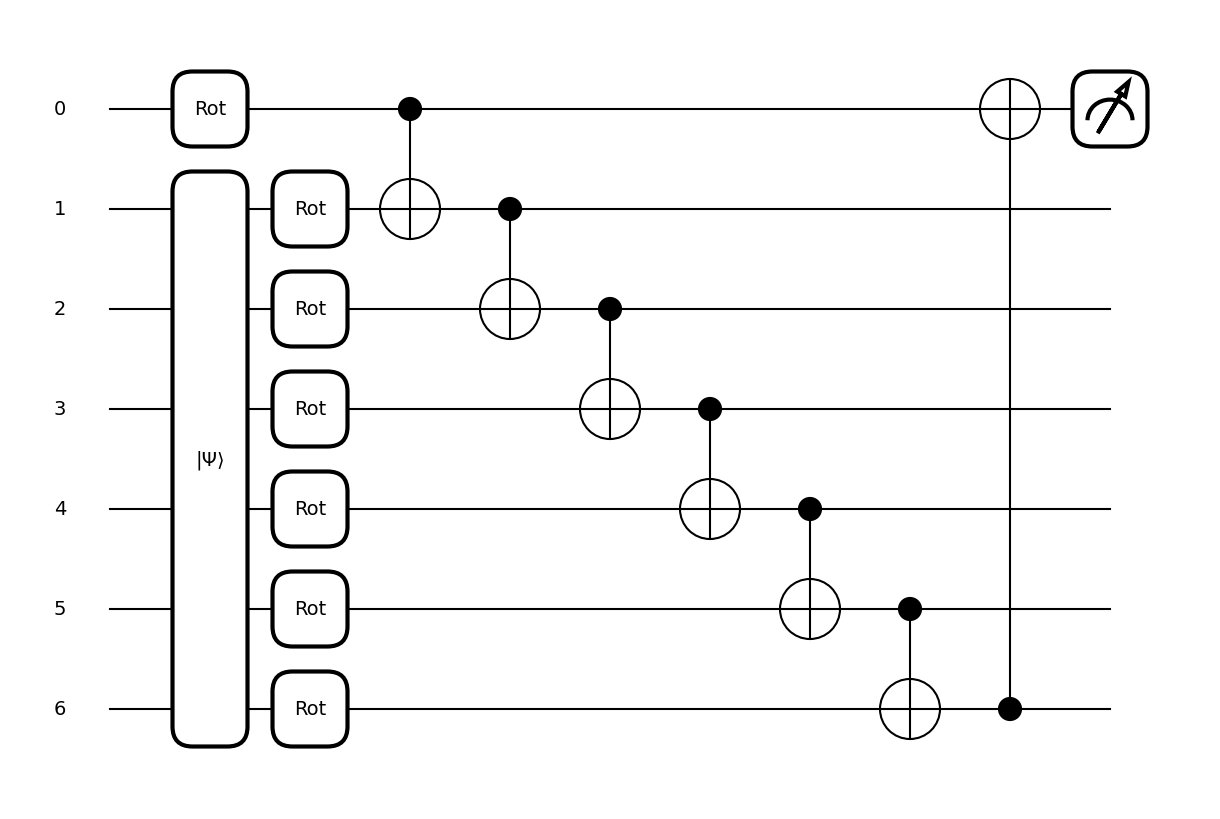

In [82]:
rng = np.random.default_rng(seed=42)
shape_input = (1, 2**(nqbits-1))
shape_weights = (1, nqbits,3)
print(qml.draw_mpl(qnode, expansion_strategy="device")(rng.random(shape_input), rng.random(shape_weights)))

Now let's create the hybrid quantum-classical model with Pytorch. To do so, we will transform the quantum node into a torch layer and add a classial layer with an activation function. 

In [92]:
weight_shapes = {"weights": (depth, nqbits,3)}
init_method = {"weights": torch.nn.init.normal_}

class TorchModel(torch.nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes, init_method=init_method)
        self.clayer = torch.nn.Linear(1, 1).double()
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.qlayer(x)
        x = x[:,0].reshape(-1,1)
        x = self.clayer(x)
        x = self.relu(x)
        return x
    
model = TorchModel()
model(torch.tensor(vector_test[:6,:]))

tensor([[0.7511],
        [0.7401],
        [0.7312],
        [0.6967],
        [0.7402],
        [0.7297]], dtype=torch.float64, grad_fn=<ReluBackward0>)

The previous code defines and initializes the quantum neural network. Make sure that the output of the model is not always 0 (this means that the QNN is not initialized properly). In that case, re-run the cell as many times as needed until you obtain a non-zero prediction.

Let's now create the training, validation and test data loaders ready for Pyroch. We now specify the batch size and the number of epochs. Then, we select a classical optimizer. In this case we select the Adam optimizer (which is a standard gradient descent optimizer). You can also play with the learning rate, which controls the velocity of the training phase.

In [93]:
batch_size = 100
epochs = 30

training_loader = torch.utils.data.DataLoader(
    list(zip(vector_train, y_train.reshape(-1,1))), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    list(zip(vector_val, y_val.reshape(-1,1))), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    list(zip(vector_test, y_test.reshape(-1,1))), batch_size=batch_size, shuffle=True)

opt = torch.optim.Adam(model.parameters(), lr=0.05)
loss = torch.nn.MSELoss()

Finally, we're ready to train the model! 

In [94]:
train_loss = []
val_loss = []
for epoch in range(epochs):

    training_losses = []
    val_losses = []
    batch=0
    for xs, ys in training_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        training_losses.append(loss_evaluated.detach())
        batch+=1

    avg_loss = np.mean(training_losses)
    train_loss.append(avg_loss)
    print("Training loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

    for xs, ys in val_loader:
        
        loss_evaluated = loss(model(xs), ys)
        val_losses.append(loss_evaluated.detach())

    avg_loss = np.mean(val_losses)
    val_loss.append(avg_loss)
    print("Validation loss over epoch {}: {:.4f}\n".format(epoch + 1, avg_loss))

Training loss over epoch 1: 0.2234
Validation loss over epoch 1: 0.1267

Training loss over epoch 2: 0.1207
Validation loss over epoch 2: 0.1491

Training loss over epoch 3: 0.1179
Validation loss over epoch 3: 0.1126

Training loss over epoch 4: 0.0890
Validation loss over epoch 4: 0.0846

Training loss over epoch 5: 0.0787
Validation loss over epoch 5: 0.0757

Training loss over epoch 6: 0.0676
Validation loss over epoch 6: 0.0638

Training loss over epoch 7: 0.0584
Validation loss over epoch 7: 0.0594

Training loss over epoch 8: 0.0506
Validation loss over epoch 8: 0.0506

Training loss over epoch 9: 0.0436
Validation loss over epoch 9: 0.0422

Training loss over epoch 10: 0.0384
Validation loss over epoch 10: 0.0347

Training loss over epoch 11: 0.0322
Validation loss over epoch 11: 0.0284

Training loss over epoch 12: 0.0261
Validation loss over epoch 12: 0.0255

Training loss over epoch 13: 0.0221
Validation loss over epoch 13: 0.0246

Training loss over epoch 14: 0.0181
Validat

Let's visualize the training of the neural network. 

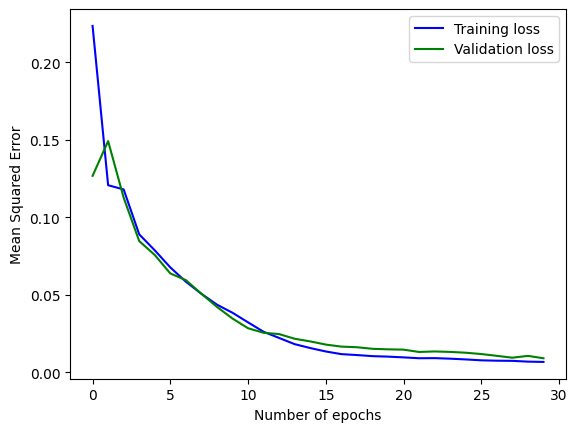

In [95]:
plt.plot(np.arange(epochs), train_loss, color='blue', label='Training loss')
plt.plot(np.arange(epochs), val_loss, color='green', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Let's make predictions in the test set.

In [96]:
y_test_pred = model(torch.tensor(vector_test))
y_test_pred = y_test_pred.detach().numpy()

In [97]:
import scipy
y_test_pred[y_test_pred<0] = 0
y_test_pred[y_test_pred>1]=1
mae_quantum = np.mean(np.abs(y_test_pred.flatten() - y_test))
mse_quantum = np.mean(np.square(y_test_pred.flatten() - y_test))
pearson_quantum = scipy.stats.pearsonr(y_test_pred.flatten(), y_test)[0]
print('MSE', mse_quantum, 'MAE', mae_quantum, 'pearson', pearson_quantum)

MSE 0.003849751914026472 MAE 0.040312643932542004 pearson 0.9864994291251887


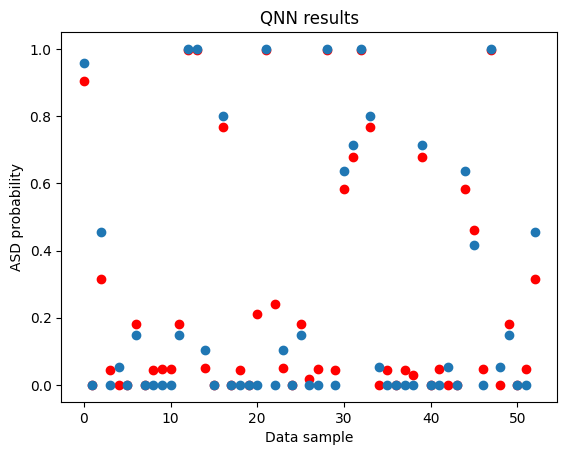

In [98]:
plt.plot(y_test_pred, 'o', color='red', label='Predicted')
plt.plot(y_test, 'o', label='True')
plt.xlabel('Data sample')
plt.ylabel('ASD probability')
plt.title('QNN results')
plt.show()

We see that our model fairly predicts the ASD probability. We could improve the predictions by modifying the hyperparameters of the model and testing new architectures.

## Exercise: Compare with a classical model

Train a classical model (it can either be a neural network, SVM, linear regression or any classical model). You can find examples of regression models here https://scikit-learn.org/stable/supervised_learning.html.
How does the performance compare with a classical model?

## Exercise: Test different QNN architectures

Vary the QNN architecture to find the one that provides best regults. You can change the variational model (check Pennylane's templates for details: https://docs.pennylane.ai/en/stable/introduction/templates.html). Can you find the most appropriate architecture?